# Problem statement: 
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 
Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. This is a Regression problem. Dataset has 17389 rows and 16 variables.


# Workflow:
- Load the dataset
- Basic data processing

## 1) Local mode training, by using a subset of large dataset

## 2) Training on SageMaker Cloud:
   - Prepare data for SageMaker cloud training:
       - Convert data to .csv and .recordio types
       - Upload training and validation datasets to S3 bucket
       
   - Specify training algorithm Docker Image
   - Build the XGBoost model
   - Specify training data location and optionally, validation data location
   - Train the model on SageMaker cloud
   - Deploy the model, and run real-time predictions
   - Evaluate the initial model (by R^2, Lift chart, RMSE, Box-plot for prediction Vs. actual values, Distribution plot of residuals)

## 3) Hyper-parameters tuning on SageMaker Cloud: Model Optimization
   - Specify range/value of hyperparameters, and launch tuning
   - Track hyper-parameter tuning job process
   - Analyze the correlation between objective metric and individual parameters
   - Deploy the best model, and run real-time predictions
   - Evaluate the best model (by R^2, Lift chart, RMSE, Box-plot for prediction Vs. actual values, Distribution plot of residuals) 






In [1]:
# Istall XGBoost package and update numpy (for the local mode):
!conda install -y -c conda-forge xgboost
!conda update -y numpy

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |           py36_1         139 KB  conda-forge

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0      --> 2018.8.24-ha4d7672_0 conda-forge
    certifi:         2018.8.24-py36_1  --> 2018.8.24-py36_1     conda-forge
    openssl:         1.0.2p-h14c3975_0 --> 1.0.2p-h470a237_0    conda-forge


certifi 2018.8.24: ##################################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environmen

In [2]:
import sklearn
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [3]:
df=pd.read_csv('bikeRental_All.csv', parse_dates=['dteday'])

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null datetime64[ns]
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(12)
memory usage: 2.3 MB


# Data Preparation/Cleaning:

In [4]:
df.drop(["yr", "mnth", "weekday"], axis=1, inplace=True)
df.set_index(['instant'], inplace=True)

In [5]:
# We need to convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def add_features(df):
    df['year'] = df['dteday'].dt.year
    df['month'] = df['dteday'].dt.month
    df['day'] = df['dteday'].dt.day
    df['dayofweek'] = df['dteday'].dt.dayofweek

add_features(df)

In [6]:
df.head(3)

,dteday,season,hr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day,dayofweek
instant,,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,0,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011,1,1,5
2,2011-01-01,1,1,0,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011,1,1,5
3,2011-01-01,1,2,0,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011,1,1,5


In [7]:
X=df.drop(['casual', 'registered', 'cnt', 'dteday'], axis=1)
y=np.log1p(df['cnt'])

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [9]:
df_train = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1) 

In [10]:
# Write to SageMaker Notebook Instance: It is saved in the folder where this ipynb was created

df_train.to_csv('bikeRental_train.csv', index=False, header=False)
df_test.to_csv('bikeRental_test.csv', index=False, header=False)

#  1) Local Mode Training (usually on a subset of data): 

In [8]:
# Building the Initial Model & Cross-Validation: 
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model=XGBRegressor(n_jobs=-1) 
kfold=KFold(n_splits=3, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.92117    0.91454369 0.92064499] 

Accuracy: 0.92 (+/- 0.00)


# 2)  Training on SageMaker Cloud

# preparing data for SageMaker cloud training: 
    - Converting data to .csv or .recodio types
    - Uploading training & validation datasets to S3 bucket

In [11]:
# Specify the Keys and Location of Train & Test datasets in S3:
bucket_name = 'roohi-ml-sagemaker'
training_file_key = 'bikeRental/bike_train.csv'
test_file_key = 'bikeRental/bike_test.csv'

s3_model_output_location = r's3://{0}/bikeRental/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,training_file_key)
s3_test_file_location = r's3://{0}/{1}'.format(bucket_name,test_file_key)

In [12]:
# Write and Reading from S3 is just as easy
# files are referred as objects in S3. File name is referred as key name in S3.
# Files stored in S3 are automatically replicated across 3 different availability zones in the region where the bucket was created.
# http://boto3.readthedocs.io/en/latest/guide/s3.html

def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: # Read in binary mode
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [13]:
write_to_s3('bikeRental_train.csv', bucket_name, training_file_key)
write_to_s3('bikeRental_test.csv', bucket_name, test_file_key)

   # Training Algorithm Docker Image:  
    Note: AWS Maintains a separate image for every region and algorithm

In [14]:
# Registry Path for algorithms provided by SageMaker
#  https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

In [15]:
role = get_execution_role()

# This role contains the permissions needed to train, deploy models
# SageMaker Service is trusted to assume this role
print(role)

arn:aws:iam::928921801380:role/service-role/AmazonSageMaker-ExecutionRole-20180831T120207


# Build model: 

In [16]:
sess = sagemaker.Session()

In [17]:
# Access appropriate algorithm container image
#  Specify how many instances to use for distributed training and what type of machine to use
#  Finally, specify where the trained model artifacts needs to be stored
#   Reference: http://sagemaker.readthedocs.io/en/latest/estimators.html
#    Optionally, give a name to the training job using base_job_name

estimator = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                       role,
                                       train_instance_count=1, 
                                       train_instance_type='ml.m4.xlarge',
                                       output_path=s3_model_output_location,
                                       sagemaker_session=sess,
                                       base_job_name ='xgboost-bikeRental-Train')

In [18]:
# Specify hyper parameters that appropriate for the training algorithm
# XGBoost Training Parameter Reference:     https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
# Also take a look this table for metrics & parameters:   https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html

param={'eval_metric':'rmse', 'gamma': 0, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7, 'num_round':100}
estimator.set_hyperparameters(**param)

estimator.hyperparameters()

{'eval_metric': 'rmse',
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 2,
 'subsample': 0.7,
 'num_round': 100}

#    Specify Training Data Location and Optionally, Validation Data Location:

In [19]:
# content type can be libsvm or csv for XGBoost
training_input_config = sagemaker.session.s3_input(s3_data=s3_training_file_location, content_type="csv")
test_input_config = sagemaker.session.s3_input(s3_data=s3_test_file_location, content_type="csv")

print(training_input_config.config)
print(test_input_config.config)

{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/bikeRental/bike_train.csv'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataDistributionType': 'FullyReplicated', 'S3DataType': 'S3Prefix', 'S3Uri': 's3://roohi-ml-sagemaker/bikeRental/bike_test.csv'}}, 'ContentType': 'csv'}


# Train the model on SM cloud:

In [20]:
# XGBoost supports "train", "validation" channels
# Reference: Supported channels by algorithm    
# https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

estimator.fit({'train': training_input_config, 'validation': test_input_config})

INFO:sagemaker:Creating training-job with name: xgboost-bikeRental-Train-2018-09-01-04-27-01-172


....................
Arguments: train
[2018-09-01:04:30:07:INFO] Running standalone xgboost training.
[2018-09-01:04:30:07:INFO] File size need to be processed in the node: 1.09mb. Available memory size in the node: 8611.3mb
[2018-09-01:04:30:07:INFO] Determined delimiter of CSV input is ','
[04:30:07] S3DistributionType set as FullyReplicated
[04:30:07] 12165x13 matrix with 158145 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2018-09-01:04:30:07:INFO] Determined delimiter of CSV input is ','
[04:30:07] S3DistributionType set as FullyReplicated
[04:30:07] 5214x13 matrix with 67782 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[04:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[0]#011train-rmse:3.05555#011validation-rmse:3.03245
[04:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]#011t


Billable seconds: 97


## Deploy Model & Run Predictions:

In [21]:
# Ref: http://sagemaker.readthedocs.io/en/latest/estimators.html
predictor = estimator.deploy(initial_instance_count=1,
                             instance_type='ml.m4.xlarge',
                             endpoint_name = 'xgboost-bikeRental-Train')

INFO:sagemaker:Creating model with name: xgboost-2018-09-01-04-30-43-342
INFO:sagemaker:Creating endpoint with name xgboost-bikeRental-Train


---------------------------------------------------------------------------!

In [22]:
# Run Predictions
from sagemaker.predictor import csv_serializer, json_deserializer

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [23]:
df_test = pd.read_csv('bikeRental_test.csv', header=None)

X_test=df_test.loc[0:, 1:].as_matrix()
y_test=df_test.loc[0:, 0].as_matrix()

In [24]:
# For large number of predictions, we can split the input data and Query the prediction service.
# array_split is convenient to specify how many splits are needed
predictions = []
for arr in np.array_split(X_test,10):
    result = predictor.predict(arr)
    result = result.decode("utf-8")
    result = result.split(',')
    print (arr.shape)
    predictions += [float(r) for r in result]

(522, 13)
(522, 13)
(522, 13)
(522, 13)
(521, 13)
(521, 13)
(521, 13)
(521, 13)
(521, 13)
(521, 13)


# Evaluate the initial model:

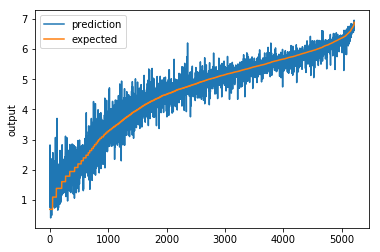

In [25]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
        plt.plot(t['pred'].tolist(),label='prediction')
        plt.plot(t['y'].tolist(),label='expected')
        plt.ylabel('output')
    plt.legend()
    plt.show()

chart_regression(predictions, y_test, sort=True)

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#pred_inv=scaler_y.inverse_transform(pd.DataFrame(predictions))
#y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(predictions)))
print('Test rmse: ', rmse)

Test rmse:  40.74703337002867


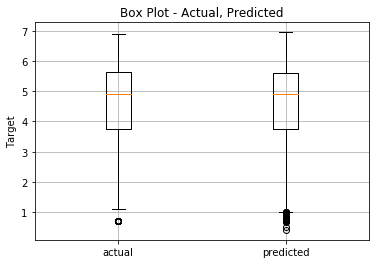

In [27]:
plt.boxplot([y_test, predictions], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

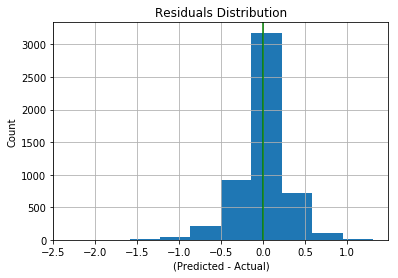

In [28]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test-predictions

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()

In [29]:
print("Validation r^2 score: ", np.round(sklearn.metrics.r2_score(y_test, predictions), 2))

Validation r^2 score:  0.96


# 3) Hyperparameters tuning on SM cloud:   Model optimization

In [30]:
from sagemaker.amazon.amazon_estimator import get_image_uri

estimatorOpt = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=s3_model_output_location,
                                    sagemaker_session=sess,
                                    base_job_name ='xgboost-bikeRental-paramTuning')

# Specify the range/value of hyperparameters & Launch tuning:

In [31]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta':ContinuousParameter(0, 1),
                        'min_child_weight':ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(1, 10)}

estimatorOpt.set_hyperparameters(eval_metric='rmse',
                        objective='reg:linear',
                        num_round=100)

In [33]:
tuner = HyperparameterTuner(estimatorOpt,
                            objective_metric_name='validation:rmse',
                            hyperparameter_ranges,
                            objective_type='Minimize',
                            max_jobs=20,
                            max_parallel_jobs=4)

In [34]:
tuner.fit({'train': training_input_config, 'validation': test_input_config})

INFO:sagemaker:Creating hyperparameter tuning job with name: xgboost-180901-0437


# Track hyperparameter tuning job progress:

In [82]:
sage_client = boto3.Session().client('sagemaker')
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
tuning_job_name = str(HyperParameterTuningJobName)

tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

# To see the best parameters found so far:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print('\n',"Best parameters found so far:")
    pprint(tuning_job_result['BestTrainingJob']['TunedHyperParameters'])
else:
    print("No training jobs have reported results yet.")

20 training jobs have completed

 Best parameters found so far:
{'alpha': '1.2055098253201972',
 'eta': '0.2412637473386472',
 'max_depth': '10',
 'min_child_weight': '8.657339194128122'}


# Analyze the correlation between objective metric and individual parameters:

In [83]:
# Finally, print the tuning jobs with best scores:

Tuner=sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
full_df = Tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df[0:3]

Number of training jobs with valid objective: 20
{'lowest': 0.28163599967956543, 'highest': 3.1679999828338623}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,eta,max_depth,min_child_weight
2,0.281636,92.0,2018-09-01 05:00:45+00:00,xgboost-180901-0437-018-62e83dae,Completed,2018-09-01 04:59:13+00:00,1.205510,0.241264,10.0,8.657339
12,0.283608,95.0,2018-09-01 04:48:33+00:00,xgboost-180901-0437-008-deddbd24,Completed,2018-09-01 04:46:58+00:00,1.174709,0.166313,10.0,1.136275
9,0.284617,98.0,2018-09-01 04:52:07+00:00,xgboost-180901-0437-011-0babf21d,Completed,2018-09-01 04:50:29+00:00,1.939785,0.149925,6.0,8.440634


In [84]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(Tuner)

ranges = Tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

Loading BokehJS ...

# Deploy the best model & do prediction:

In [70]:
bestModel_location =r'https://s3.amazonaws.com/roohi-ml-sagemaker/bikeRental/model/'+df.iloc[0][3]+'/output/model.tar.gz'

In [71]:
bestModel = sagemaker.model.Model (model_data = bestModel_location, 
                                  image = containers[boto3.Session().region_name],
                                  role = role,
                                  sagemaker_session = sess)

In [72]:
bestModel.deploy(initial_instance_count = 1,
                 instance_type = 'ml.m4.xlarge',
                 endpoint_name = 'xgboost-bikeRental-Optimized')

INFO:sagemaker:Creating model with name: xgboost-2018-09-01-05-06-02-026
INFO:sagemaker:Creating endpoint with name xgboost-bikeRental-Optimized


--------------------------------------------------------------!

In [73]:
predictor_tuned = sagemaker.predictor.RealTimePredictor(endpoint='xgboost-bikeRental-Optimized',
                                                        sagemaker_session=sess)

In [74]:
# Run Predictions
from sagemaker.predictor import csv_serializer, json_deserializer

predictor_tuned.content_type = 'text/csv'
predictor_tuned.serializer = csv_serializer
predictor_tuned.deserializer = None

In [76]:
# For large number of predictions, we can split the input data and Query the prediction service.
# array_split is convenient to specify how many splits are needed
predictions = []
for arr in np.array_split(X_test,10):
    result = predictor_tuned.predict(arr)
    result = result.decode("utf-8")
    result = result.split(',')
    print (arr.shape)
    predictions += [float(r) for r in result]

(522, 13)
(522, 13)
(522, 13)
(522, 13)
(521, 13)
(521, 13)
(521, 13)
(521, 13)
(521, 13)
(521, 13)


# Evaluation of best model: 

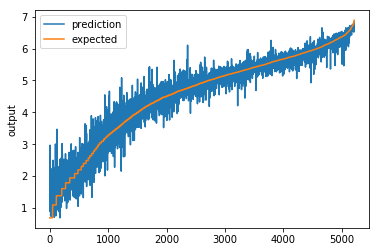

In [77]:
# Plot the Lift Chart:
chart_regression(predictions, y_test, sort=True)

In [78]:
#pred_inv=scaler_y.inverse_transform(pd.DataFrame(predictions))
#y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.expm1(y_test), np.expm1(predictions)))
print('Test rmse: ', rmse)

Test rmse:  36.88854613764194


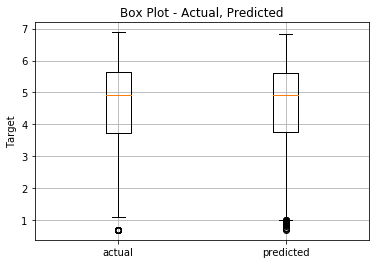

In [79]:
plt.boxplot([y_test, predictions], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

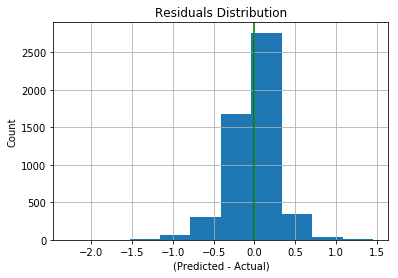

In [80]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test-predictions

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()

In [81]:
# boto3.Session().client('sagemaker').delete_endpoint(EndpointName='xgboost-bikeRental-Optimized')